# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
# Importing libraries
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import math
import json
from progressbar import progressbar
from progressbar import progressbar
from time import time

# Visualisation library
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sb
color = sb.color_palette()[0]
sb.set_color_codes("pastel")

# Machine learning library
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.svm import SVC

In [2]:
# Defining custom function here
def plot_hist(data, xlabel='x', ylabel='y', title='t', bins=None, 
              v_line=False, alpha=1, label=None):
    plt.hist(data, bins=bins, alpha=alpha, label=label);
    plt.xlabel(xlabel);
    plt.ylabel(ylabel);
    plt.title(title);
    if v_line:
        plt.axvline(data.mean(), color=v_line)
    
def plot_count(data, xlabel='x', ylabel='y', title='t'):
    sb.countplot(data, color=color);
    plt.xlabel(xlabel);
    plt.ylabel(ylabel);
    plt.title(title);

In [3]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### Data Cleaning and Exploration

#### Cleaning `portfolio` Dataset

In [4]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [5]:
# Creating dict to simplify offer id
portfolio_dict = {'ae264e3637204a6fb9bb56bc8210ddfd': 'bogo1',
       '4d5c57ea9a6940dd891ad53e9dbe8da0': 'bogo2',
       '3f207df678b143eea3cee63160fa8bed': 'info1',
       '9b98b8c7a33c4b65b9aebfe6a799e6d9': 'bogo3',
       '0b1e1539f2cc45b7b9fa7c272da2e1d7': 'disc1',
       '2298d6c36e964ae4a3e7e9706d1fb8c2': 'disc2',
       'fafdcd668e3743c1bb461111dcafc2a4': 'disc3',
       '5a8bc65990b245e5a138643cd4eb9837': 'info2',
       'f19421c1d4aa40978ebb69ca19b0e20d': 'bogo4',
       '2906b810c7d4411798c6938adc9daaa5': 'disc4'}

In [6]:
portfolio['id'] = portfolio['id'].replace(portfolio_dict)

In [7]:
# Convert duration from days to hours
portfolio['duration'] = portfolio['duration'] * 24

In [8]:
# Expanding and creating dummy for values inside channels column
mlb = MultiLabelBinarizer()
channel_expanded = pd.DataFrame(mlb.fit_transform(portfolio['channels']), 
                                columns=mlb.classes_)
portfolio = pd.concat([channel_expanded, portfolio], axis=1).drop('channels', 
                                                                  axis=1)

In [9]:
portfolio

,email,mobile,social,web,reward,difficulty,duration,offer_type,id
0,1,1,1,0,10,10,168,bogo,bogo1
1,1,1,1,1,10,10,120,bogo,bogo2
2,1,1,0,1,0,0,96,informational,info1
3,1,1,0,1,5,5,168,bogo,bogo3
4,1,0,0,1,5,20,240,discount,disc1
5,1,1,1,1,3,7,168,discount,disc2
6,1,1,1,1,2,10,240,discount,disc3
7,1,1,1,0,0,0,72,informational,info2
8,1,1,1,1,5,5,120,bogo,bogo4
9,1,1,0,1,2,10,168,discount,disc4


#### Cleaning `profile` Dataset

In [10]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [11]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [12]:
# Converting became_member_on type from int to datetime
profile['became_member_on'] = pd.to_datetime(profile['became_member_on']
                                             .astype('str'))

In [13]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN


#### Cleaning `transcript` Dataset

In [14]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [15]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [16]:
# Costly function here, please see below for faster execution time
# start = time()
# transcript_added = transcript['value'].apply(pd.Series)

# now = time()
# print(f'Elapsed time: {(now-start)/60}m..')

In [17]:
# Expanding dict inside value column
start = time()
transcript_added2 = pd.io.json.json_normalize(transcript['value'])

now = time()
print(f'Elapsed time: {(now-start)/60:.2f}m..')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


Elapsed time: 0.03m..


In [18]:
# Joining separated value in 'offer_id' and 'offer id' columns
transcript_added2['offer_id'] = (transcript_added2['offer id']
                                 .replace(np.nan, '') 
                                 + transcript_added2['offer_id']
                                 .replace(np.nan, '')).replace('', np.nan)

In [19]:
# Dropping unused column
transcript_added2 = transcript_added2.drop('offer id', axis=1)

In [20]:
# Making sure they have same length
transcript.shape, transcript_added2.shape

((306534, 4), (306534, 3))

In [21]:
# Joining expanded value column into source dataset
transcript = pd.concat([transcript, transcript_added2], axis=1).drop('value', axis=1)

In [22]:
# Replacing values inside offer_id with simplified value
transcript['offer_id'] = transcript['offer_id'].replace(portfolio_dict)

In [23]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   person    306534 non-null  object 
 1   event     306534 non-null  object 
 2   time      306534 non-null  int64  
 3   amount    138953 non-null  float64
 4   offer_id  167581 non-null  object 
 5   reward    33579 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 14.0+ MB


In [24]:
transcript.head()

,person,event,time,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,bogo3,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,disc1,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,disc4,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,disc3,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,bogo2,NaN


#### Data Exploration

Before we go move further, we need to list what we want to extract from the given data.

We have data about Starbucks offers, customer, and event happened for each user. From this data. it looks like we can gain some answers from questions like these below:
1. What type of offer giving the highest ads to transaction conversion?
2. What is the customer demographic for that type of offer?
3. Is it any difference between female and male customer?

In [25]:
portfolio

,email,mobile,social,web,reward,difficulty,duration,offer_type,id
0,1,1,1,0,10,10,168,bogo,bogo1
1,1,1,1,1,10,10,120,bogo,bogo2
2,1,1,0,1,0,0,96,informational,info1
3,1,1,0,1,5,5,168,bogo,bogo3
4,1,0,0,1,5,20,240,discount,disc1
5,1,1,1,1,3,7,168,discount,disc2
6,1,1,1,1,2,10,240,discount,disc3
7,1,1,1,0,0,0,72,informational,info2
8,1,1,1,1,5,5,120,bogo,bogo4
9,1,1,0,1,2,10,168,discount,disc4


In [26]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN


In [27]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   gender            14825 non-null  object        
 1   age               17000 non-null  int64         
 2   id                17000 non-null  object        
 3   became_member_on  17000 non-null  datetime64[ns]
 4   income            14825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 664.2+ KB


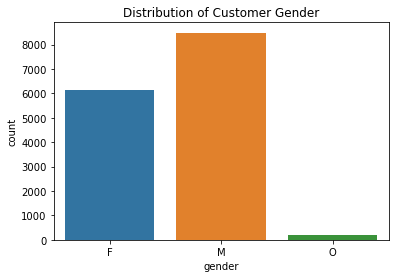

In [83]:
sb.countplot(profile['gender']);
plt.title('Distribution of Customer Gender');
plt.savefig('Distribution of Customer Gender', dpi=1000);

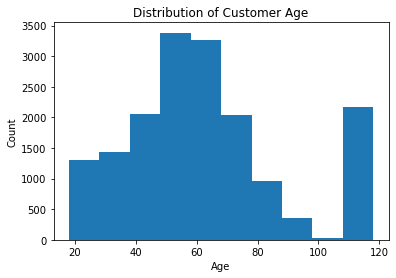

In [29]:
plot_hist(profile['age'], 'Age', 'Count', 'Distribution of Customer Age');

In [30]:
profile[profile['age'] == 118].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 16994
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   gender            0 non-null      object        
 1   age               2175 non-null   int64         
 2   id                2175 non-null   object        
 3   became_member_on  2175 non-null   datetime64[ns]
 4   income            0 non-null      float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 102.0+ KB


In [31]:
profile[profile['age'] == 118].head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,2017-09-25,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,2017-10-02,NaN


There is customer who did not input personal data to the app. As we can see, the system filled the data with default settings which are:
- 118 for `age`
- None for `gender`
- NaN for `income`

We need to separate this group from our analysis.

In [32]:
# Separating row with less information
profile = profile[profile['age'] != 118]

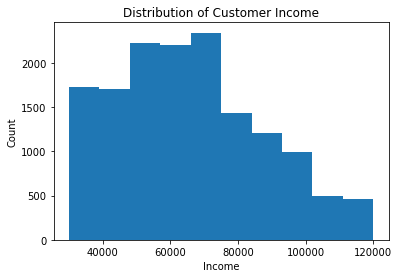

In [33]:
# Checking result
plot_hist(profile[~profile['income'].isna()]['income'], 'Income', 'Count',
          'Distribution of Customer Income');

In [34]:
# Extract year from registration date 
profile['reg_year'] = profile['became_member_on'].apply(lambda x: x.year)

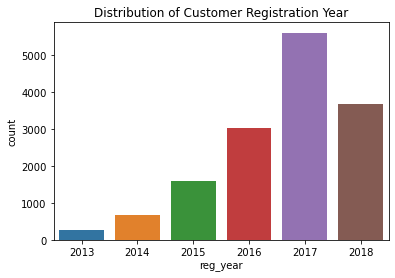

In [86]:
sb.countplot(profile['reg_year']);
plt.title('Distribution of Customer Registration Year');
plt.savefig('Distribution of Customer Registration Year', dpi=1000);

In [36]:
transcript.head()

,person,event,time,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,bogo3,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,disc1,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,disc4,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,disc3,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,bogo2,NaN


In [37]:
# Making replacement dict from values inside 'event' column
event = enumerate(transcript['event'].unique())
event_dict = {v: k for k, v in event}
event_dict

{'offer received': 0,
 'offer viewed': 1,
 'transaction': 2,
 'offer completed': 3}

In [38]:
# Making replacement dict from values inside 'offer_id' column
offer_id = enumerate(transcript['offer_id'].unique())
offer_id_dict = {v: k for k, v in offer_id}
offer_id_dict.pop(np.nan, None)
offer_id_dict

{'bogo3': 0,
 'disc1': 1,
 'disc4': 2,
 'disc3': 3,
 'bogo2': 4,
 'bogo4': 5,
 'disc2': 6,
 'info1': 7,
 'bogo1': 8,
 'info2': 9}

In [39]:
transcript.isna().sum()

person           0
event            0
time             0
amount      167581
offer_id    138953
reward      272955
dtype: int64

Those missing value in transcript dataset are came from transaction event and informational offer type. We should fill it with zeroes.

In [40]:
# Filling missing values with zeroes
transcript_clean = transcript.copy()
transcript_clean['event'] = transcript_clean['event'].replace(event_dict)
transcript_clean['amount'] = transcript_clean['amount'].fillna(0)
transcript_clean['reward'] = transcript_clean['reward'].fillna(0)
transcript_clean.head()


,person,event,time,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,0.0,bogo3,0.0
1,a03223e636434f42ac4c3df47e8bac43,0,0,0.0,disc1,0.0
2,e2127556f4f64592b11af22de27a7932,0,0,0.0,disc4,0.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,0.0,disc3,0.0
4,68617ca6246f4fbc85e91a2a49552598,0,0,0.0,bogo2,0.0


In [41]:
transcript_clean.isna().sum()

person           0
event            0
time             0
amount           0
offer_id    138953
reward           0
dtype: int64

In [42]:
transcript_clean.describe()

,event,time,amount,reward
count,306534.000000,306534.000000,306534.000000,306534.000000
mean,1.423555,366.382940,5.792023,0.537219
std,0.980266,200.326314,21.337137,1.805208
min,0.000000,0.000000,0.000000,0.000000
25%,1.000000,186.000000,0.000000,0.000000
50%,2.000000,408.000000,0.000000,0.000000
75%,2.000000,528.000000,7.100000,0.000000
max,3.000000,714.000000,1062.280000,10.000000


In [43]:
transcript['offer_id'].unique()

array(['bogo3', 'disc1', 'disc4', 'disc3', 'bogo2', 'bogo4', 'disc2',
       'info1', 'bogo1', 'info2', nan], dtype=object)

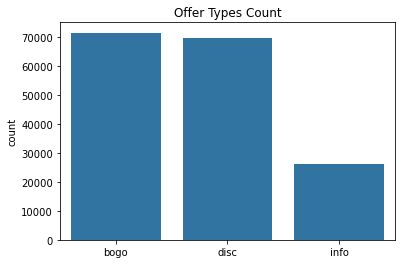

In [44]:
offer = [id[:-1] for id in transcript['offer_id'] if str(id) != 'nan']
sb.countplot(offer, color=color);
plt.title('Offer Types Count');

In [45]:
# Making sure customers inside profile dataset is available in transcript dataset
transcript_clean['person'].isin(profile['id']).any()

True

In [46]:
transcript_clean['person'].nunique(),  profile['id'].nunique()

(17000, 14825)

Looks like almost all of our customer is recorded in transcipt dataset. The difference in unique count is due to dropped rows in profile dataset.<br>
It would be better if we merge required data into one dataset.

In [47]:
df = pd.merge(transcript_clean, portfolio, how='outer', left_on='offer_id', 
              right_on='id').drop('id', axis=1)\
    .rename(columns={'reward_y': 'reward_offer', 'reward_x': 'reward_given'})

In [48]:
df = pd.merge(profile, df, left_on='id', right_on='person')\
    .drop('person', axis=1).rename(columns={'id': 'person_id'})

In [49]:
df.head()

,gender,age,person_id,became_member_on,income,reg_year,event,time,amount,offer_id,reward_given,email,mobile,social,web,reward_offer,difficulty,duration,offer_type
0,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,0,408,0.00,bogo3,0.0,1.0,1.0,0.0,1.0,5.0,5.0,168.0,bogo
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,3,528,0.00,bogo3,5.0,1.0,1.0,0.0,1.0,5.0,5.0,168.0,bogo
2,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,0,504,0.00,info1,0.0,1.0,1.0,0.0,1.0,0.0,0.0,96.0,informational
3,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,2,18,21.51,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,2,144,32.28,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


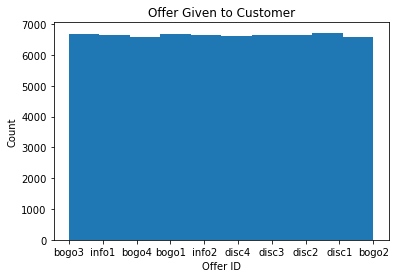

In [87]:
plot_hist(df[df['event'] == 0]['offer_id'], xlabel='Offer ID', ylabel='Count', title='Offer Given to Customer')
plt.savefig('Offer Given to Customer.png', dpi=1000);

The figure above suggest Starbucks count spread equally between different offer. We can see the same count received by our customer for each offer. Therefore, we can continue to analyze the data and make comparation between its features.<br>

First, let's find customers who are affected by offer:
- Customer who can be categorized as affected must first received the offer.
- Customer must view the offer.
- Customer must make transaction within offer duration. 

Customer who received the offer but did not manage to see it is categorized as unaffected or unsuccess, so does with the customer who received it, saw it, but did not make the transaction.

In [51]:
# Let's review data inside df dataset
df.sample(5).sort_values(by=['person_id', 'time'])

,gender,age,person_id,became_member_on,income,reg_year,event,time,amount,offer_id,reward_given,email,mobile,social,web,reward_offer,difficulty,duration,offer_type
5191,M,73,0861b9ca31b741bb8b411b18f82d18f6,2017-06-27,92000.0,2017,0,408,0.00,bogo4,0.0,1.0,1.0,1.0,1.0,5.0,5.0,120.0,bogo
256432,M,69,1f6ad0a8def240b3ad633f83032dedd8,2013-08-01,73000.0,2013,2,594,5.85,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
257753,M,19,6676062b996d42499314026f12c2efac,2016-02-04,74000.0,2016,2,510,18.40,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34174,M,62,7d4d5d017ac54e688e9aa20d6a01af81,2017-07-30,79000.0,2017,3,432,0.00,disc3,2.0,1.0,1.0,1.0,1.0,2.0,10.0,240.0,discount
266563,F,52,c2e92293563f471784aeb176661ed097,2018-03-19,64000.0,2018,1,594,0.00,bogo1,0.0,1.0,1.0,1.0,0.0,10.0,10.0,168.0,bogo


In [52]:
# Take a peek for a user data
user_data = df[df['person_id'] == 'baee294f84ec4a059c92e36df084e206']\
            .sort_values(by=['person_id', 'time'])
user_data

,gender,age,person_id,became_member_on,income,reg_year,event,time,amount,offer_id,reward_given,email,mobile,social,web,reward_offer,difficulty,duration,offer_type
155313,M,48,baee294f84ec4a059c92e36df084e206,2017-12-01,98000.0,2017,0,0,0.00,bogo1,0.0,1.0,1.0,1.0,0.0,10.0,10.0,168.0,bogo
155314,M,48,baee294f84ec4a059c92e36df084e206,2017-12-01,98000.0,2017,1,72,0.00,bogo1,0.0,1.0,1.0,1.0,0.0,10.0,10.0,168.0,bogo
155310,M,48,baee294f84ec4a059c92e36df084e206,2017-12-01,98000.0,2017,0,336,0.00,bogo4,0.0,1.0,1.0,1.0,1.0,5.0,5.0,120.0,bogo
155311,M,48,baee294f84ec4a059c92e36df084e206,2017-12-01,98000.0,2017,1,336,0.00,bogo4,0.0,1.0,1.0,1.0,1.0,5.0,5.0,120.0,bogo
155312,M,48,baee294f84ec4a059c92e36df084e206,2017-12-01,98000.0,2017,3,378,0.00,bogo4,5.0,1.0,1.0,1.0,1.0,5.0,5.0,120.0,bogo
155317,M,48,baee294f84ec4a059c92e36df084e206,2017-12-01,98000.0,2017,2,378,27.50,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
155315,M,48,baee294f84ec4a059c92e36df084e206,2017-12-01,98000.0,2017,0,408,0.00,info2,0.0,1.0,1.0,1.0,0.0,0.0,0.0,72.0,informational
155316,M,48,baee294f84ec4a059c92e36df084e206,2017-12-01,98000.0,2017,1,432,0.00,info2,0.0,1.0,1.0,1.0,0.0,0.0,0.0,72.0,informational
155318,M,48,baee294f84ec4a059c92e36df084e206,2017-12-01,98000.0,2017,2,486,25.15,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
155319,M,48,baee294f84ec4a059c92e36df084e206,2017-12-01,98000.0,2017,2,540,19.94,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
# Separating user who succesfully completing offers with others who do not.
user_offer = {}
unaffected = {}

for user in progressbar(df['person_id'].unique()):
    user_data = df[df['person_id'] == user].sort_values(by=['person_id', 
                                                            'time'])
    unique_offer = np.setdiff1d(user_data['offer_id'].unique()
                                .astype('str'), np.array(['nan']))
    success_offer = []
    no_success = []
    
    for offer in unique_offer:
        # Finding time when user received the offer
        offer_info = user_data[(user_data['offer_id'] == offer) 
                               & ((user_data['event'] == 0))]
        time = offer_info['time'].values[0]
        duration = offer_info['duration'].values[0]
        data_sliced = user_data[(user_data['time'] >= time) 
                                & (user_data['time'] <= time + duration)]
        data_sliced['event'].values
        # Finding whether user 
        if ((1 in data_sliced['event'].values) 
            & (2 in data_sliced['event'].values)):
            success_offer.append(offer)
        else:
            no_success.append(offer)
            
    if len(success_offer) > 0:
        user_offer[user] = success_offer
    if len(no_success) > 0:
        unaffected[user] = no_success

100% (14825 of 14825) |##################| Elapsed Time: 0:09:29 Time:  0:09:29


In [54]:
# Print out the number of user in each category
len(user_offer), len(unaffected)

(13804, 10065)

In [55]:
user_offer

{'78afa995795e4d85b5d9ceeca43f5fef': ['bogo1', 'bogo3', 'bogo4', 'info2'],
 'e2127556f4f64592b11af22de27a7932': ['bogo3', 'disc3'],
 '389bc3fa690240e798340f5a15918d5c': ['bogo4', 'disc3', 'disc4'],
 '2eeac8d8feae4a8cad5a6af0499a211d': ['disc2', 'disc3'],
 'aa4862eba776480b8bb9c68455b8c2e1': ['bogo1', 'bogo2', 'bogo4', 'disc1'],
 'e12aeaf2d47d42479ea1c4ac3d8286c6': ['bogo1'],
 '31dda685af34476cad5bc968bdb01c53': ['disc2', 'disc3'],
 '62cf5e10845442329191fc246e7bcea3': ['bogo1', 'info2'],
 '6445de3b47274c759400cd68131d91b4': ['bogo3', 'disc2'],
 'a448667f336b42c9a66fc5ffd5d73772': ['bogo1'],
 '440cf1fd7580490c971d8c651ed962af': ['disc1', 'disc2'],
 '4b0da7e80e5945209a1fdddfe813dbe0': ['disc1', 'info1'],
 'c27e0d6ab72c455a8bb66d980963de60': ['disc3', 'info1', 'info2'],
 'f806632c011441378d4646567f357a21': ['bogo2', 'disc3', 'info1'],
 'd058f73bf8674a26a95227db098147b1': ['bogo2', 'disc1', 'disc4'],
 'c6c9884912c645429f3333f912b55f44': ['disc1', 'disc2', 'disc3'],
 '7429a044884842d6862f516

In [56]:
unaffected

{'0610b486422d4921ae7d2bf64640c50b': ['bogo3', 'info1'],
 'e2127556f4f64592b11af22de27a7932': ['disc4', 'info1'],
 '389bc3fa690240e798340f5a15918d5c': ['bogo3'],
 '2eeac8d8feae4a8cad5a6af0499a211d': ['info1'],
 'aa4862eba776480b8bb9c68455b8c2e1': ['info2'],
 'e12aeaf2d47d42479ea1c4ac3d8286c6': ['disc1', 'disc4'],
 '31dda685af34476cad5bc968bdb01c53': ['disc1'],
 '62cf5e10845442329191fc246e7bcea3': ['disc1'],
 '6445de3b47274c759400cd68131d91b4': ['disc1', 'info1'],
 'a448667f336b42c9a66fc5ffd5d73772': ['bogo3', 'info2'],
 '440cf1fd7580490c971d8c651ed962af': ['disc4'],
 '4b0da7e80e5945209a1fdddfe813dbe0': ['bogo1'],
 'c27e0d6ab72c455a8bb66d980963de60': ['bogo2'],
 'd058f73bf8674a26a95227db098147b1': ['bogo3'],
 'c6c9884912c645429f3333f912b55f44': ['bogo3', 'disc4'],
 '7429a044884842d6862f516c38b1156f': ['info1'],
 'ebe7ef46ea6f4963a7dd49f501b26779': ['bogo3'],
 'd1ede868e29245ea91818a903fec04c6': ['bogo3', 'disc4'],
 '1e9420836d554513ab90eba98552d0a9': ['bogo1'],
 '868317b9be554cb18e50bc6

In [57]:
# Creating dataframe consist of user with success offer
user_offer_df = pd.DataFrame({'user': list(user_offer.keys()), 
                              'success_offer': list(user_offer.values())})
user_offer_df = user_offer_df.explode('success_offer').reset_index(drop=True)\
                .sort_values(by=['user', 'success_offer'])
user_offer_df.sample(5)

,user,success_offer
35065,1f4d50d43cfe4547b3dd37d318a83b0a,disc3
27846,194c17ebab614744a501d5ef67c3b010,info2
16648,4f0dcdd442f845248a28fe45f85ec9a6,bogo1
34952,39e169565ff64c0796f8136fb9ba08d9,disc3
29051,23a5ad19280748efb6e49781c6042e1a,disc3


In [58]:
# Creating dataframe consist of user with unsuccess offer
unaffected_df = pd.DataFrame({'user': list(unaffected.keys()),
                              'unsuccess_offer': list(unaffected.values())})
unaffected_df = unaffected_df.explode('unsuccess_offer')\
                .reset_index(drop=True).sort_values(by=['user', 
                                                        'unsuccess_offer'])
unaffected_df.head()

,user,unsuccess_offer
3885,0009655768c64bdeb2e877511632db8f,disc4
4312,0011e0d4e6b944f998e987f904e8c1e5,info1
4313,0011e0d4e6b944f998e987f904e8c1e5,info2
2579,0020c2b971eb4e9188eac86d93036a77,bogo1
2580,0020c2b971eb4e9188eac86d93036a77,info2


In [59]:
# Merging dataset with offer information
new_df = pd.merge(user_offer_df, portfolio, left_on='success_offer', 
                  right_on='id').drop('id', axis=1)\
        .sort_values(by=['user', 'success_offer'])
new_df.head()

,user,success_offer,email,mobile,social,web,reward,difficulty,duration,offer_type
0,0009655768c64bdeb2e877511632db8f,bogo4,1,1,1,1,5,5,120,bogo
4224,0009655768c64bdeb2e877511632db8f,disc3,1,1,1,1,2,10,240,discount
9224,0009655768c64bdeb2e877511632db8f,info1,1,1,0,1,0,0,96,informational
11274,0009655768c64bdeb2e877511632db8f,info2,1,1,1,0,0,0,72,informational
14341,0011e0d4e6b944f998e987f904e8c1e5,bogo3,1,1,0,1,5,5,168,bogo


In [60]:
# Merging dataset with offer information
unsuccess_offer_df = pd.merge(unaffected_df, portfolio, 
                              left_on='unsuccess_offer', right_on='id')\
                    .drop('id', axis=1).sort_values(by=['user', 
                                                        'unsuccess_offer'])
unsuccess_offer_df.head()

,user,unsuccess_offer,email,mobile,social,web,reward,difficulty,duration,offer_type
0,0009655768c64bdeb2e877511632db8f,disc4,1,1,0,1,2,10,168,discount
2377,0011e0d4e6b944f998e987f904e8c1e5,info1,1,1,0,1,0,0,96,informational
5851,0011e0d4e6b944f998e987f904e8c1e5,info2,1,1,1,0,0,0,72,informational
8301,0020c2b971eb4e9188eac86d93036a77,bogo1,1,1,1,0,10,10,168,bogo
5852,0020c2b971eb4e9188eac86d93036a77,info2,1,1,1,0,0,0,72,informational


In [61]:
# Merging dataset with user information
new_df = pd.merge(profile, new_df, left_on='id', right_on='user')\
        .drop('id', axis=1).sort_values(by=['user', 'success_offer'])
user = new_df['user']
new_df.insert(0, 'user_id', user)
new_df.drop(['user'], axis=1, inplace=True)
new_df.head()

,user_id,gender,age,became_member_on,income,reg_year,success_offer,email,mobile,social,web,reward,difficulty,duration,offer_type
8316,0009655768c64bdeb2e877511632db8f,M,33,2017-04-21,72000.0,2017,bogo4,1,1,1,1,5,5,120,bogo
8317,0009655768c64bdeb2e877511632db8f,M,33,2017-04-21,72000.0,2017,disc3,1,1,1,1,2,10,240,discount
8318,0009655768c64bdeb2e877511632db8f,M,33,2017-04-21,72000.0,2017,info1,1,1,0,1,0,0,96,informational
8319,0009655768c64bdeb2e877511632db8f,M,33,2017-04-21,72000.0,2017,info2,1,1,1,0,0,0,72,informational
9240,0011e0d4e6b944f998e987f904e8c1e5,O,40,2018-01-09,57000.0,2018,bogo3,1,1,0,1,5,5,168,bogo


In [62]:
# Merging dataset with user information
unsuccess_offer_df = pd.merge(profile, unsuccess_offer_df, left_on='id', 
                              right_on='user').drop('id', axis=1)\
                    .sort_values(by=['user', 'unsuccess_offer'])
user = unsuccess_offer_df['user']
unsuccess_offer_df.insert(0, 'user_id', user)
unsuccess_offer_df.drop(['user'], axis=1, inplace=True)
unsuccess_offer_df.head()

,user_id,gender,age,became_member_on,income,reg_year,unsuccess_offer,email,mobile,social,web,reward,difficulty,duration,offer_type
3885,0009655768c64bdeb2e877511632db8f,M,33,2017-04-21,72000.0,2017,disc4,1,1,0,1,2,10,168,discount
4312,0011e0d4e6b944f998e987f904e8c1e5,O,40,2018-01-09,57000.0,2018,info1,1,1,0,1,0,0,96,informational
4313,0011e0d4e6b944f998e987f904e8c1e5,O,40,2018-01-09,57000.0,2018,info2,1,1,1,0,0,0,72,informational
2579,0020c2b971eb4e9188eac86d93036a77,F,59,2016-03-04,90000.0,2016,bogo1,1,1,1,0,10,10,168,bogo
2580,0020c2b971eb4e9188eac86d93036a77,F,59,2016-03-04,90000.0,2016,info2,1,1,1,0,0,0,72,informational


bogo             0.729988
discount         0.734527
informational    0.463454
Name: offer_type, dtype: float64


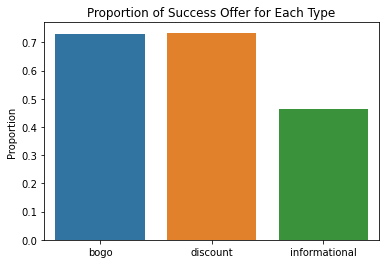

In [84]:
# Finding the highest conversion rate for each offer type
total = new_df['offer_type'].value_counts().sort_index()\
        + unsuccess_offer_df['offer_type'].value_counts().sort_index()

print(new_df['offer_type'].value_counts().sort_index() / total)

sb.barplot(x=(new_df['offer_type'].value_counts().sort_index() / total)
           .index, y=new_df['offer_type'].value_counts().sort_index() / total);
plt.title('Proportion of Success Offer for Each Type');
plt.ylabel('Proportion');
plt.savefig('Proportion of Success Offer', dpi=1000);

As we can see above, discount offer has the highest ads convertion proportion compared with other offers. We should see customer demography that affected by that kind of offer.

In [64]:
new_df_discount = new_df[new_df['offer_type'] == 'discount']

There is differences between female and male customers. It is a good idea to separate the and look at the differences.

#### Feature: reg_year

Mean Values: 		Std Dev.:
 'M': 2016.5		1.3
 'F': 2016.5		1.1


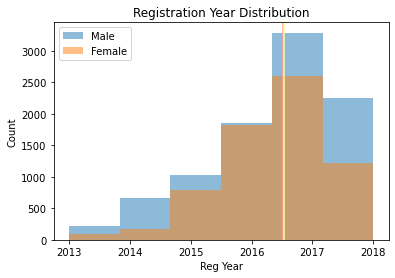

In [81]:
mean_male = new_df_discount[new_df_discount['gender'] == 'M']['reg_year'].mean()
mean_female = new_df_discount[new_df_discount['gender'] == 'F']['reg_year'].mean()
std_male = new_df_discount[new_df_discount['gender'] == 'M']['reg_year'].std()
std_female = new_df_discount[new_df_discount['gender'] == 'F']['reg_year'].std()

print(f"Mean Values: \t\tStd Dev.:\n",
      f"'M': {mean_male:.1f}\t\t{std_male:.1f}\n",
      f"'F': {mean_female:.1f}\t\t{std_female:.1f}")
plot_hist(new_df_discount[new_df_discount['gender'] == 'M']['reg_year'], 
          bins=6, v_line='r', alpha=0.5, label='Male')
plot_hist(new_df_discount[new_df_discount['gender'] == 'F']['reg_year'], 
          bins=6, v_line='y', alpha=0.5, xlabel='Reg Year', ylabel='Count', 
          title='Registration Year Distribution', label='Female')
plt.legend();
plt.savefig('Customer Registration Year Distribution', dpi=1000);

There is no difference between female and male customer in registration year. Customer who registered their account between 2016 and 2017 has highest count. The only difference we got is that male customer has higher count than female customer. We better continue our analysis to other features.

#### Feature: age

Mean Values: 		Std Dev.:
 'M': 52.1		17.4
 'F': 57.0		16.8


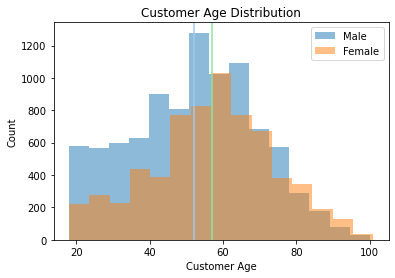

In [80]:
mean_male = new_df_discount[new_df_discount['gender'] == 'M']['age'].mean()
mean_female = new_df_discount[new_df_discount['gender'] == 'F']['age'].mean()
std_male = new_df_discount[new_df_discount['gender'] == 'M']['age'].std()
std_female = new_df_discount[new_df_discount['gender'] == 'F']['age'].std()

print(f"Mean Values: \t\tStd Dev.:\n",
      f"'M': {mean_male:.1f}\t\t{std_male:.1f}\n",
      f"'F': {mean_female:.1f}\t\t{std_female:.1f}")
plot_hist(new_df_discount[new_df_discount['gender'] == 'M']['age'], 
          bins=15, v_line='b', alpha=0.5, label='Male')
plot_hist(new_df_discount[new_df_discount['gender'] == 'F']['age'], 
          xlabel='Customer Age', ylabel='Count', 
          title='Customer Age Distribution', bins=15, v_line='g', alpha=0.5, 
          label='Female')
plt.legend();
plt.savefig('Customer Age Distribution', dpi=1000);

By looking to the figure, the older female customer is more likely to be influenced by offer. This is also happened to male customer. The female customer age distribution is peaked at around 60's while the male customer is at 50's. The figure also shows that Starbucks has  male customer who is affected by offer younger in average than female customers.

#### Feature: income

Mean Values: 		Std Dev.:
 'M': 61287.7		19780.1
 'F': 70495.9		21979.7


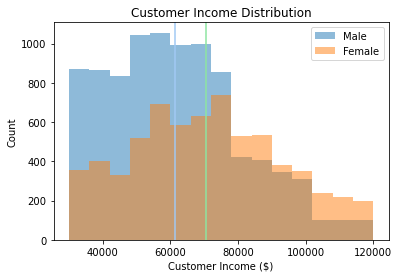

In [79]:
mean_male = new_df_discount[new_df_discount['gender'] == 'M']['income'].mean()
mean_female = new_df_discount[new_df_discount['gender'] == 'F']['income'].mean()
std_male = new_df_discount[new_df_discount['gender'] == 'M']['income'].std()
std_female = new_df_discount[new_df_discount['gender'] == 'F']['income'].std()

print(f"Mean Values: \t\tStd Dev.:\n",
      f"'M': {mean_male:.1f}\t\t{std_male:.1f}\n",
      f"'F': {mean_female:.1f}\t\t{std_female:.1f}")
plot_hist(new_df_discount[new_df_discount['gender'] == 'M']['income'], 
          bins=15, v_line='b', alpha=0.5, label='Male')
plot_hist(new_df_discount[new_df_discount['gender'] == 'F']['income'], 
          xlabel='Customer Income ($)', ylabel='Count', 
          title='Customer Income Distribution', bins=15, v_line='g', 
          alpha=0.5, label='Female')
plt.legend();
plt.savefig('Customer Income Distribution', dpi=1000);

Starbucks male customer who make transaction after seeing the offer has lower average earnings compared to the female customer in average. Male customer has average earnings around \\$60k and has higher count in earnings range between \\$30k and \\$75k. On the other side, female customer has higher earning in average. Customer count is higher for female with earning between \\$5k and \\$120k.

### Data Modelling

We could also predict offer type for each customer given some information about the reward, difficulty, offer duration and the information about the user itself. This prediction can be used as offer targetting and is expected to make higher offer convertion than just randomly send users the offer.

In [68]:
new_df.head()

,user_id,gender,age,became_member_on,income,reg_year,success_offer,email,mobile,social,web,reward,difficulty,duration,offer_type
8316,0009655768c64bdeb2e877511632db8f,M,33,2017-04-21,72000.0,2017,bogo4,1,1,1,1,5,5,120,bogo
8317,0009655768c64bdeb2e877511632db8f,M,33,2017-04-21,72000.0,2017,disc3,1,1,1,1,2,10,240,discount
8318,0009655768c64bdeb2e877511632db8f,M,33,2017-04-21,72000.0,2017,info1,1,1,0,1,0,0,96,informational
8319,0009655768c64bdeb2e877511632db8f,M,33,2017-04-21,72000.0,2017,info2,1,1,1,0,0,0,72,informational
9240,0011e0d4e6b944f998e987f904e8c1e5,O,40,2018-01-09,57000.0,2018,bogo3,1,1,0,1,5,5,168,bogo


In [69]:
# Selecting features that will be included in machine learning model
to_analyse1 = new_df.copy()[['gender', 'age', 'income', 'reward','difficulty',
                             'duration', 'offer_type']]
to_analyse2 = unsuccess_offer_df.copy()[['gender', 'age', 'income', 'reward',
                                         'difficulty', 'duration', 'offer_type']]
to_analyse2['offer_type'] = ['not_recommended'] * len(unsuccess_offer_df)
to_analyse = pd.concat([to_analyse1, to_analyse2], ignore_index=True)
to_analyse.sample(5)

,gender,age,income,reward,difficulty,duration,offer_type
4608,M,36,34000.0,0,0,72,informational
43455,M,33,54000.0,5,20,240,not_recommended
23651,F,50,67000.0,5,5,120,bogo
16817,M,92,30000.0,5,5,168,bogo
26782,M,71,73000.0,2,10,168,discount


In [70]:
# Creating dict for replacement
gender = set(to_analyse['gender'])
gender_dict = {k: v for v, k in enumerate(gender)}
print('gender_dict:', gender_dict)

offer_type = set(to_analyse['offer_type'])
offer_type_dict = {k: v for v, k in enumerate(offer_type)}
print('offer_type_dict:', offer_type_dict)

gender_dict: {'F': 0, 'M': 1, 'O': 2}
offer_type_dict: {'informational': 0, 'discount': 1, 'not_recommended': 2, 'bogo': 3}


In [71]:
# Replace value with defined dict
to_analyse['gender'].replace(gender_dict, inplace=True)
to_analyse['offer_type'].replace(offer_type_dict, inplace=True)

In [72]:
# Making dummy for gender feature
dataset = to_analyse.copy()
dataset = pd.get_dummies(dataset, columns=['gender']).drop('gender_1', axis=1)
dataset.head()

,age,income,reward,difficulty,duration,offer_type,gender_0,gender_2
0,33,72000.0,5,5,120,3,0,0
1,33,72000.0,2,10,240,1,0,0
2,33,72000.0,0,0,96,0,0,0
3,33,72000.0,0,0,72,0,0,0
4,40,57000.0,5,5,168,3,0,1


In [73]:
# Splitting dataset
X = dataset[['age', 'income', 'reward', 'difficulty', 'duration', 'gender_0', 
             'gender_2']]
y = dataset['offer_type']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

##### Logistic Regression

In [74]:
# Train logistic regression model
pipeline = Pipeline([('scaler', StandardScaler()),
                     ('clf', LogisticRegression(random_state=42, 
                                                max_iter=500))])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(f'Accuracy Score: {accuracy_score(y_test, y_pred)}.. ')

Accuracy Score: 0.6050267999420542.. 


##### Support Vector Classifier

In [75]:
# Train support vector model
pipeline = Pipeline([('scaler', StandardScaler()),
                     ('clf', SVC(random_state=42))])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(f'Accuracy Score: {accuracy_score(y_test, y_pred)}.. ')

Accuracy Score: 0.7094741416775315.. 


##### AdaBoost Classifier

In [76]:
# Train adaboost model
pipeline = Pipeline([('scaler', StandardScaler()),
                     ('clf', AdaBoostClassifier(random_state=42))])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(f'Accuracy Score: {accuracy_score(y_test, y_pred)}.. ')

Accuracy Score: 0.6697088222511951.. 


##### Random Forest Classifier

In [77]:
# Train random forest model
pipeline = Pipeline([('scaler', StandardScaler()),
                     ('clf', RandomForestClassifier(random_state=42))])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(f'Accuracy Score: {accuracy_score(y_test, y_pred)}.. ')

Accuracy Score: 0.6570331739823265.. 


SVC gives the highest accuracy score, we should refine its parameters to obtain better results. Here we use GridSearchCV to obtain the best parameter for our SVC model.

In [83]:
pipeline = Pipeline([('scaler', StandardScaler()),
                     ('clf', SVC(random_state=42))])

parameters = {
              'clf__C':[0.5, 1, 10, 100]}

cv = GridSearchCV(pipeline, param_grid=parameters, verbose=60, n_jobs=3)

cv.fit(X_train, y_train)
y_pred = cv.predict(X_test)

print(f'Accuracy Score: {accuracy_score(y_test, y_pred)}.. ')

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 tasks      | elapsed:  1.3min
[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:  1.3min
[Parallel(n_jobs=3)]: Done   3 tasks      | elapsed:  1.3min
[Parallel(n_jobs=3)]: Done   4 tasks      | elapsed:  2.6min
[Parallel(n_jobs=3)]: Done   5 tasks      | elapsed:  2.7min
[Parallel(n_jobs=3)]: Done   6 tasks      | elapsed:  2.8min
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:  4.0min
[Parallel(n_jobs=3)]: Done   8 tasks      | elapsed:  4.0min
[Parallel(n_jobs=3)]: Done   9 tasks      | elapsed:  4.1min
[Parallel(n_jobs=3)]: Done  10 tasks      | elapsed:  5.4min
[Parallel(n_jobs=3)]: Done  11 tasks      | elapsed:  7.0min
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:  7.2min
[Parallel(n_jobs=3)]: Done  13 tasks      | elapsed:  8.3min
[Parallel(n_jobs=3)]: Done  14 tasks      | elapsed:  9.6min
[Parallel(n

In [84]:
cv.best_params_

{'clf__C': 100}

Our SVC model accuracy score is improved by a little margin. It looks like the basic parameter can model the data well.

### Conclusion<br>

The given data has been explored and analyzed. Some insight have been found:

1. The best offer type is discount. Discounted product brings highest ads conversion.
2. Male customer count is higher than female ones. It looks like that male customer drinks coffee much more than female customer.
3. There is no difference between female and male customer in registration year. Starbucks should target customer who registered their account in between 2016 and 2017.
4. The customer between 50 and 60 years old is more likely to be influenced by offer. The female customer age distribution is peaked at around 60's while the male customer is at 50's. Starbucks should focus their offer to younger male and older female for better ads conversion.
5. Starbucks male customer who make transaction after seeing the offer has lower average earnings compared to the female customer. Male customer has average earnings around \\$60k and has higher count in earnings range between \\$30k and \\$75k. On the other side, count is higher for female customer with earning between \\$5k and \\$120k.
6. We have built machine learning model to help company to predict what is the best offer to give to their customer. This prediction will help Starbucks to improve their offer to transaction conversion rate.